In [1]:
import pickle
import torch 
import control as ct
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
from random import randint, uniform
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch.optim as optim
from torch.utils.data import random_split
from numpy import linalg as LA
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import Plotter

print(torch.cuda.is_available())
!nvidia-smi
device = torch.device("cuda:0")

/home/george/Documents/Research/KoopmanTheory/Koopman/Orbital Koopman - Second Paper/Two Body Problem/Plotter.py:161: SyntaxWarning: invalid escape sequence '\c'
  ax[1,0].set_title('$r \cdot v$ Metric',fontsize=16)


True
Wed Feb 19 11:24:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3090        Off |   00000000:06:00.0  On |                  N/A |
| 30%   42C    P5             34W /  350W |    1201MiB /  24576MiB |     30%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+

In [2]:
# function to output the nonlinear dynamics of the orbit
def orbitdyn2D(t,x,mu):
    r = torch.sqrt(x[0,0]**2 + x[1,0]**2) # magnitude of position vector
    ax = -mu*x[0,0]/r**3 # acceleration in x-dir based on two-body problem
    ay = -mu*x[1,0]/r**3 # acceleration in y-dir based on two-body problem

    fdyn = torch.tensor([[x[2]], [x[3]], [ax], [ay]])
    return fdyn


# runge-kutta fourth-order numerical integration
def rk4(func, tk, _yk, mu, _dt, *args):

    # evaluate derivative at several stages within time interval
    f1 = func(tk, _yk, mu, *args)
    f2 = func(tk + _dt / 2, _yk + (f1 * (_dt / 2)), mu, *args)
    f3 = func(tk + _dt / 2, _yk + (f2 * (_dt / 2)), mu, *args)
    f4 = func(tk + _dt, _yk + (f3 * _dt), mu, *args)

    # return an average of the derivative over tk, tk + dt
    return _yk + (_dt / 6) * (f1 + (2 * f2) + (2 * f3) + f4)

In [3]:
# loading training data and stacking into 3D array for batch training
data_x = torch.load("X_Data.pt", weights_only=False)
data_x = torch.FloatTensor(np.stack((data_x)))
data_y = torch.load("Y_Data.pt", weights_only=False)
data_y = torch.FloatTensor(np.stack((data_y)))
data_y2 = torch.load("Y2_Data.pt", weights_only=False)
data_y2 = torch.FloatTensor(np.stack((data_y2)))

# loading parametric variables
with open('twobody_data_variables.pkl', 'rb') as f: 
    dp,dt,nx,m,predict_time,e = pickle.load(f)
    
# loading the training data for batch training
loader = DataLoader(list(zip(data_x, data_y, data_y2)), shuffle=True, batch_size=128)

# ***Building the Network***

In [4]:
# Hyperparameters
input_size = nx 
lifted_space = 6
hidden_size = 25
learning_rate = 0.00001
P = torch.cat((torch.eye(nx),torch.zeros(nx,lifted_space)),1).to(device)

class Encoder(nn.Module):
    def __init__(self, input_size, lifted_space):
        super(Encoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, hidden_size),
            torch.nn.SELU(),
            torch.nn.Linear(hidden_size, lifted_space)
        )

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
          encoded = self.encoder(x)
          return encoded         

modelen = Encoder(input_size, lifted_space).to(device)
criterion = torch.nn.MSELoss().to(device) # mean squared loss 
optimizer = optim.Adam(list(modelen.parameters()), lr=learning_rate, weight_decay=1e-5)

# ***Training***

In [5]:
num_epochs = 12000
Loss = []
Loss_prev = 1e38
iterations = 10

for iter in range(iterations): 
    i = 0
    j = 0

    for epoch in range(num_epochs):
        for part_x, part_y, part_y2 in loader:
            
            # stacking the training dataset into a 2D array
            train_x = torch.tensor(np.hstack(part_x)).float().to(device)
            train_y = torch.tensor(np.hstack(part_y)).float().to(device)
            train_y2 = torch.tensor(np.hstack(part_y2)).float().to(device)
            
            # encoding the states and adding the original states to the encoded x data
            phi_k = torch.transpose(modelen(torch.transpose(train_x,0,1)),0,1)
            phi_k = torch.cat((train_x,phi_k),0)   

            # encoding the states and adding the original states to the encoded y data
            phi_kp1 = torch.transpose(modelen(torch.transpose(train_y,0,1)),0,1)
            phi_kp1 = torch.cat((train_y,phi_kp1),0) 
            
            #~~~~~~~~~~~~~~~~~~~~~ EDMD ~~~~~~~~~~~~~~~~~~~~~~#
            K = torch.matmul(phi_kp1,torch.pinverse(phi_k)) 
            
            #~~~~~~~~~~~~~~~~~ Multiple Time Step Predicition Loss ~~~~~~~~~~~~~~~~~#
            for l in range(predict_time):
                next_phi = torch.matmul(K,phi_k)
                next_state = torch.matmul(P,next_phi)
                next_state_encoded = torch.transpose(modelen(torch.transpose(next_state,0,1)),0,1)
                phi_k = torch.cat((next_state,next_state_encoded),0)

            loss_x = next_state
            loss_y = train_y2
            loss_1 = criterion(loss_x, loss_y) # prediction loss

            #~~~~~~~~~~~~~~~ One Time Step Prediction loss ~~~~~~~~~~~~~~~~~~~~~~#
            phi_hat_p1 = torch.matmul(K,phi_k)
            x_p1 = torch.matmul(P,phi_hat_p1)

            loss_2 = criterion(x_p1, train_y) # reconstruction loss

            rdotv_pred = next_state[0,:]*next_state[2,:] + next_state[1,:]*next_state[3,:]
            rdotv_exact = train_y2[0,:]-train_y2[0,:]
            rdotvloss = criterion(rdotv_pred, rdotv_exact) # rdotv loss

            # loss function lambdas
            loss_1_lambda = 0.8
            loss_2_lambda = 1
            loss_rdotv_lambda = 0.05
            l1_lambda = 0.04
            l2_lambda = 0.01

            l1_regularisation = sum(p.norm().sum()
                  for p in modelen.parameters())
            loss_L1 = l1_lambda * l1_regularisation

            l2_regularisation = sum(p.pow(2.0).sum()
                  for p in modelen.parameters())
            loss_L2 = l2_lambda * l2_regularisation

            loss = loss_1_lambda*loss_1 + loss_2_lambda*loss_2 + loss_L1 + loss_L2 + loss_rdotv_lambda*rdotvloss
            
            # Backward and optimize
            optimizer.zero_grad() # find the gradients.
            loss.backward(retain_graph=True) # backprop
            optimizer.step() # updates the weights for the each parameter.

            # storing the K value and model of the best model trained so far
            if loss.item() < Loss_prev or (iter == 0 and epoch == 0):
                best_model = modelen
                torch.save(modelen, '2BPbest-model-test.pt')
                K_best = K
                Loss_prev = loss.item()
            modelen = best_model

        # logging of losses
        if (i+1) % 100 == 0:
            print (f'Iteration: [{iter+1}/{iterations}],   Epoch: [{epoch+1}/{num_epochs}],  Loss: {loss.item():.15f},   Loss 1: {loss_1_lambda*loss_1},   Loss 2: {loss_2_lambda*loss_2},   L1 Loss: {loss_L1}, L2 Loss: {loss_L2}, rdotv Loss: {loss_rdotv_lambda*rdotvloss}')
        i = i+1
        Loss.append(loss.item())

    # storing the best K to a data file
    with open('2BPobjs-test.pkl', 'wb') as f:
        pickle.dump(K_best, f)

Iteration: [1/20],   Epoch: [100/12000],  Loss: 1.434274435043335,   Loss 1: 0.0009185430826619267,   Loss 2: 1.891466240522277e-06,   L1 Loss: 0.6170327067375183, L2 Loss: 0.6398695111274719, rdotv Loss: 0.17645178735256195
Iteration: [1/20],   Epoch: [200/12000],  Loss: 1.384057402610779,   Loss 1: 0.0010538330534473062,   Loss 2: 2.160954636565293e-06,   L1 Loss: 0.6165059804916382, L2 Loss: 0.6385860443115234, rdotv Loss: 0.1279093474149704
Iteration: [1/20],   Epoch: [300/12000],  Loss: 1.726970553398132,   Loss 1: 0.0015809007454663515,   Loss 2: 3.2398161238234024e-06,   L1 Loss: 0.6163033246994019, L2 Loss: 0.6376481652259827, rdotv Loss: 0.47143492102622986
Iteration: [1/20],   Epoch: [400/12000],  Loss: 1.337875485420227,   Loss 1: 0.0019426000071689487,   Loss 2: 3.956391992687713e-06,   L1 Loss: 0.6157982349395752, L2 Loss: 0.6367089748382568, rdotv Loss: 0.08342165499925613
Iteration: [1/20],   Epoch: [500/12000],  Loss: 1.326137423515320,   Loss 1: 0.001464057364501059,  

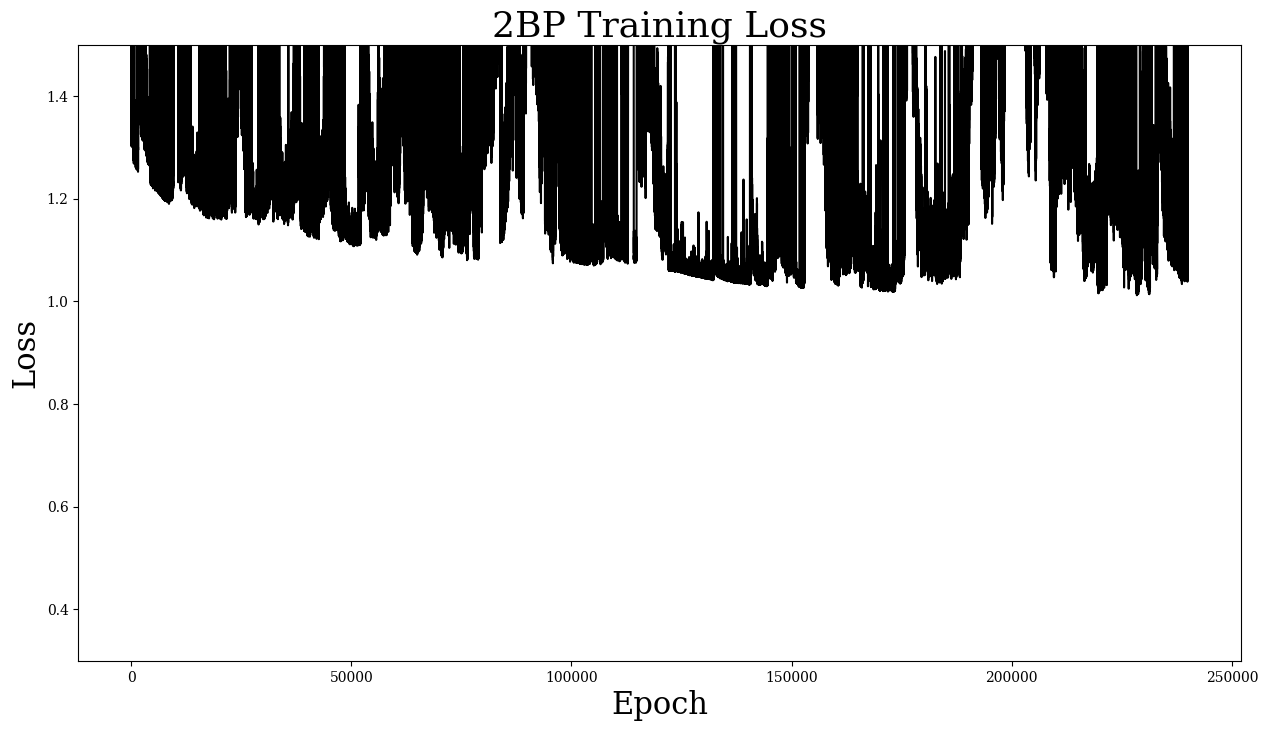

In [ ]:
# plotting training loss
mpl.rc('font',family='Serif')
fig, ax = plt.subplots(figsize = (15, 8))
lns = ax.plot(Loss, color='black', label = 'RLDK model')
ax.set_xlabel("Epoch", fontsize = 22)
ax.set_ylabel('Loss', fontsize = 22)
ax.set_title("2BP Training Loss", fontsize=26)
# ax.set_ylim([0.3,1.5])
plt.show()

# ***Plotting Eccentric Orbits and States w/ Local and Global Errors***

In [5]:
# ~~~~~~~~~~~~~~ Loading trained models ~~~~~~~~~~~~~~ #
model_circ = torch.load('2BPbest-model-test.pt',weights_only=False)
model_01 = torch.load('2BPbest-model01.pt',weights_only=False)
model_02 = torch.load('2BPbest-model02.pt',weights_only=False)
model_05 = torch.load('2BPbest-model05.pt',weights_only=False)

with open('2BPobjs-test.pkl', 'rb') as f: 
    K = pickle.load(f)

with open('2BPobjs01.pkl', 'rb') as f: 
    K_01 = pickle.load(f)

with open('2BPobjs02.pkl', 'rb') as f: 
    K_02 = pickle.load(f)

with open('2BPobjs05.pkl', 'rb') as f: 
    K_05 = pickle.load(f)

models = [model_05, model_02, model_01, model_circ]
Ks = [K_05, K_02, K_01, K]

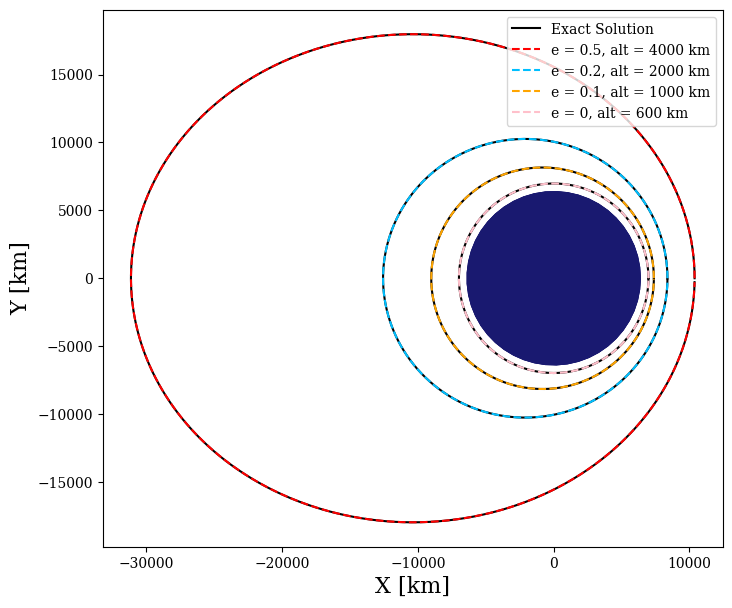

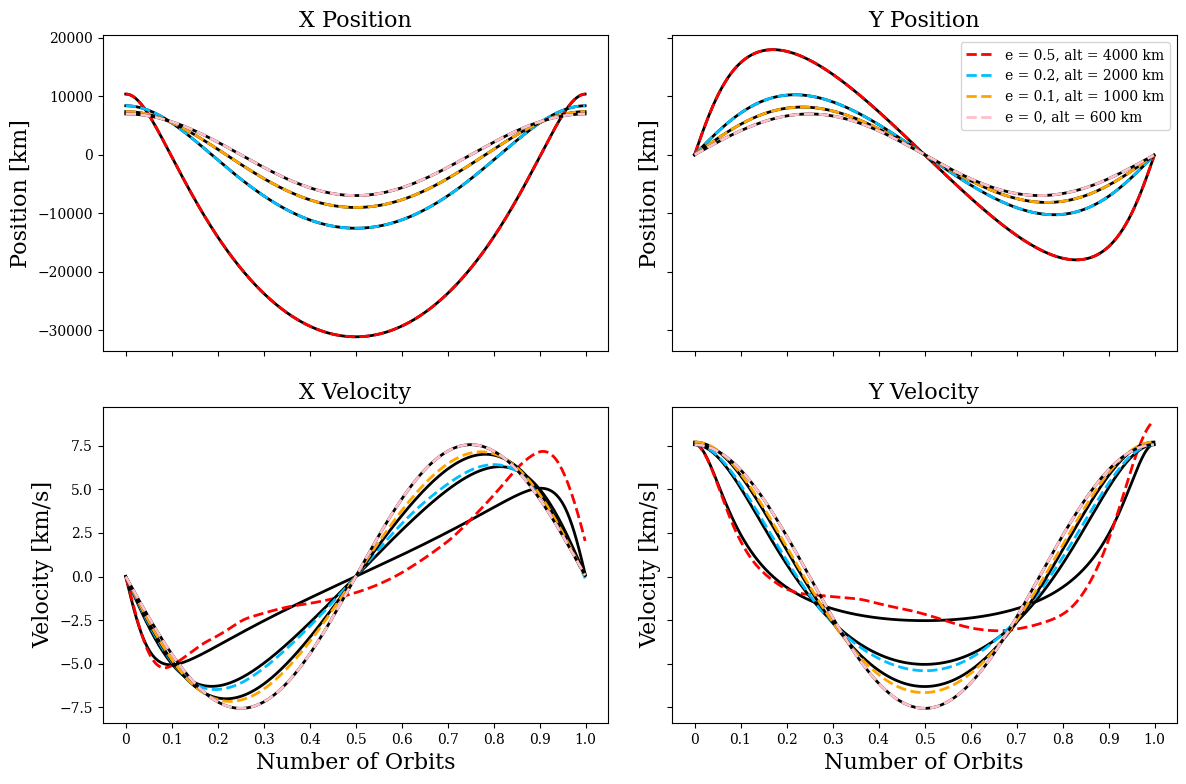

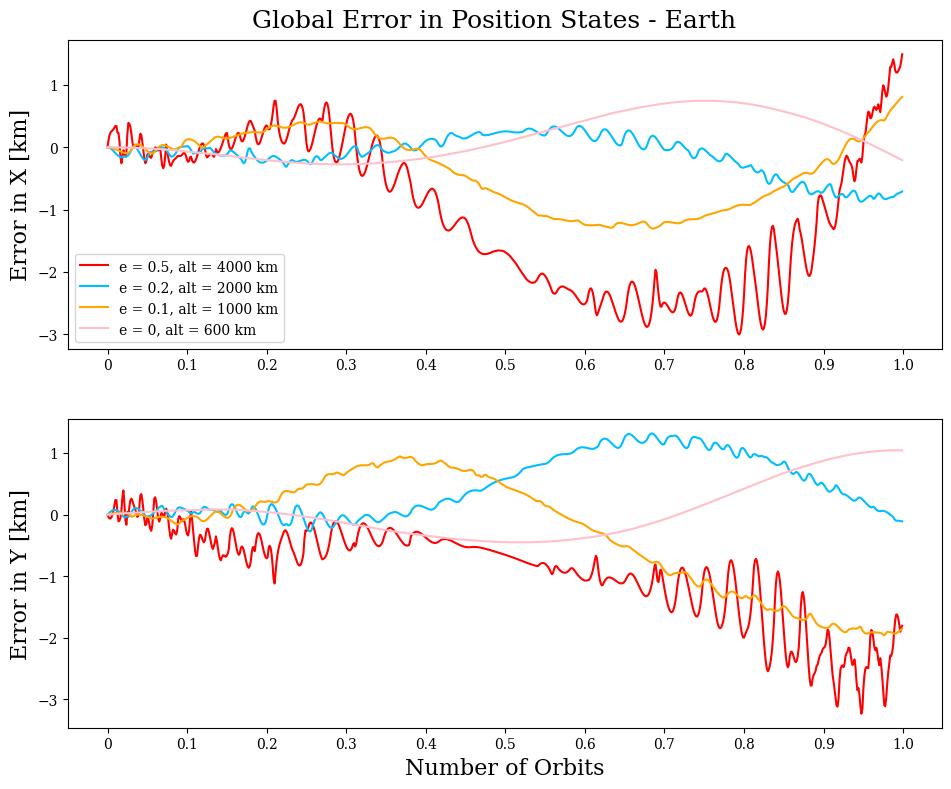

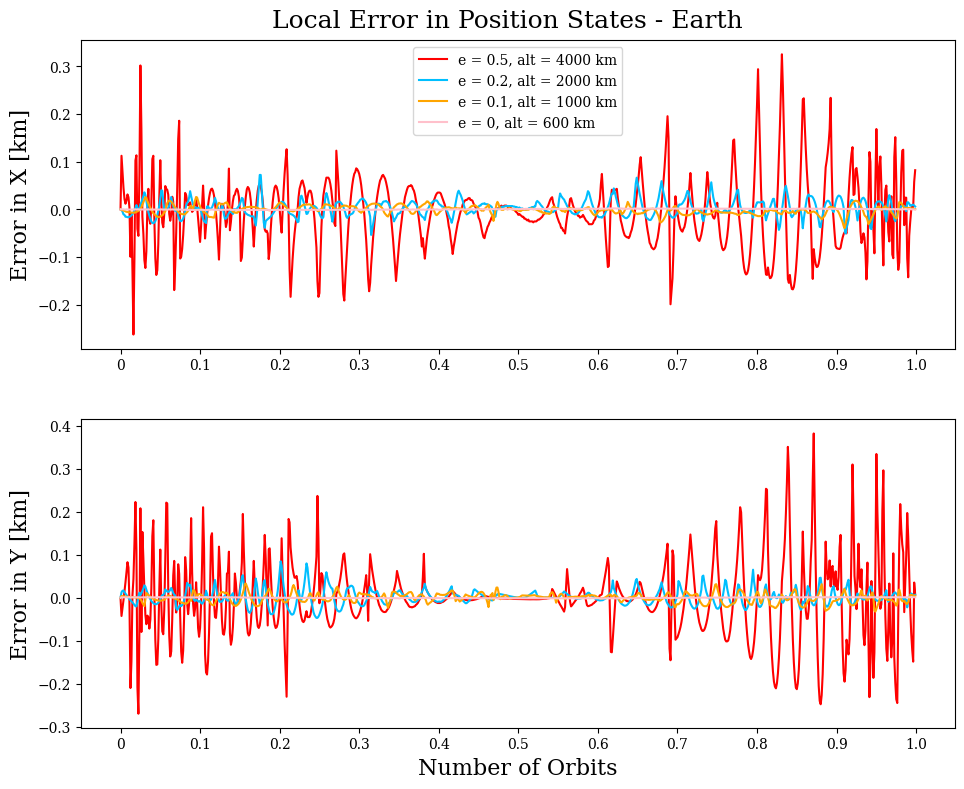

In [ ]:
# Two Body Problem parameters
G = 6.6742e-20 # Gravitational constant [m^3*kg^-1*s^-2]
r_Earth = 6378.14  # Average radius of Earth [km]
m1 = 5.974e24 # mass of Earth [kg]
m2 = 1000 # mass of satellite [kg]
mu_Earth = G*(m1 + m2) # gravitational parameter [km^3*s^-2]
alts = [4000, 2000, 1000, 600]
ecc = [0.5, 0.2, 0.1, 0]
num_traj = len(alts)
num_orbits = 1
dp = num_orbits*800

# object arrays to store the trajectories
globalPredArray = np.empty(num_traj, dtype=object)
localPredArray = np.empty(num_traj, dtype=object)
exact = np.empty(num_traj, dtype=object)

# Orbital Dynamics 
for j, (alt, model, K, e) in enumerate(zip(alts, models, Ks, ecc)):
    rp = r_Earth + alt # radius of Perigee [km]
    ra = (rp + e*rp)/(1-e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = int(2*torch.pi*(a**3/mu_Earth)**0.5) # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu_Earth*((2/rp) - (1/a)))**0.5

    x_0 = torch.tensor([[x], [y], [x_dot], [y_dot]])
    time = np.linspace(0, num_orbits*int(period), dp)
    dt = num_orbits*int(period)/dp

    # ~~~~~~ Creating array to store system state at time k ~~~~~~~ #
    globalPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of global loss
    localPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of local loss
    NL_sol = torch.empty([nx,0]) # separate trajectory for the nonlinear system
    i = 0

    # ~~~~~~ Creating tensors to store system states ~~~~~~~ #
    xG = x_0.to(device)
    xL = x_0.to(device)
    xk = x_0

# ~~~~~~ System Evolution ~~~~~~~ #
    for t in time:

        # ~~~~~~~~ Saving Current State in Array ~~~~~~~~ #
        globalPred = torch.hstack((globalPred, xG)) # saving states
        localPred = torch.hstack((localPred, xL)) # saving states

        # ~~~~~~~~~~ Lifting of States ~~~~~~~~~~ #
        globalEncoded = model(torch.transpose(xG,0,1))
        localEncoded = model(torch.transpose(xk,0,1).to(device))
        phihatGlobal = torch.cat((xG,torch.transpose(globalEncoded,0,1)),0)
        phihatLocal = torch.cat((xk.to(device),torch.transpose(localEncoded,0,1)),0)

        # ~~~~~~~~~ Straight Koopman Prediction ~~~~~~~~~ #
        phihatGlobal_p1 = torch.matmul(K, phihatGlobal)
        phihatLocal_p1 = torch.matmul(K, phihatLocal)

        # ~~~~~~~~~~ Extracting States ~~~~~~~~~~ #
        xG = torch.matmul(P,phihatGlobal_p1) # extracting the next state
        xL = torch.matmul(P,phihatLocal_p1) # extracting the next state

        # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
        NL_sol = np.hstack((NL_sol, xk))
        xk = rk4(orbitdyn2D, t, xk, mu_Earth, dt) # RK4 approximation of solution
        i = i+1

    globalPredArray[j] = globalPred
    localPredArray[j] = localPred
    exact[j] = NL_sol

# ~~~~~~~~~~~~~~~~~~~~ Plotting the orbits ~~~~~~~~~~~~~~~~~~~~~~#

Earth_plot = Plotter.Plotter(exact, globalPredArray, r_Earth, alts, ecc, num_orbits, 'Earth', 0, 'ecc')
Earth_plot.perifocalPlot()

# ~~~~~~~~~~~~~~~~~~~ Plotting the States ~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.statePlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Global Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.errorPlot('Global')

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Local Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
Earth_plot = Plotter.Plotter(exact, localPredArray, r_Earth, alts, ecc, num_orbits, 'Earth', 0, 'ecc')
Earth_plot.errorPlot('Local')


# ***Plotting Circular Earth Orbits and States w/ Local and Global Errors***

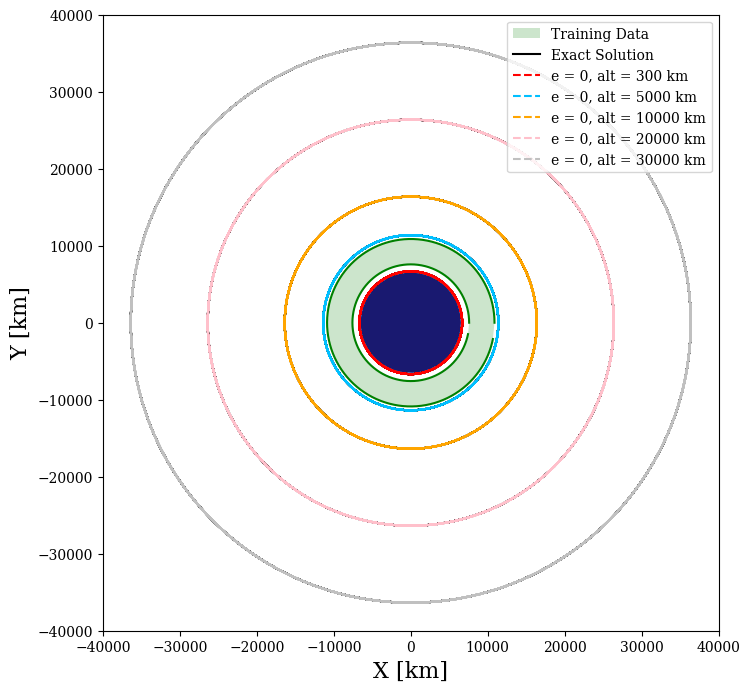

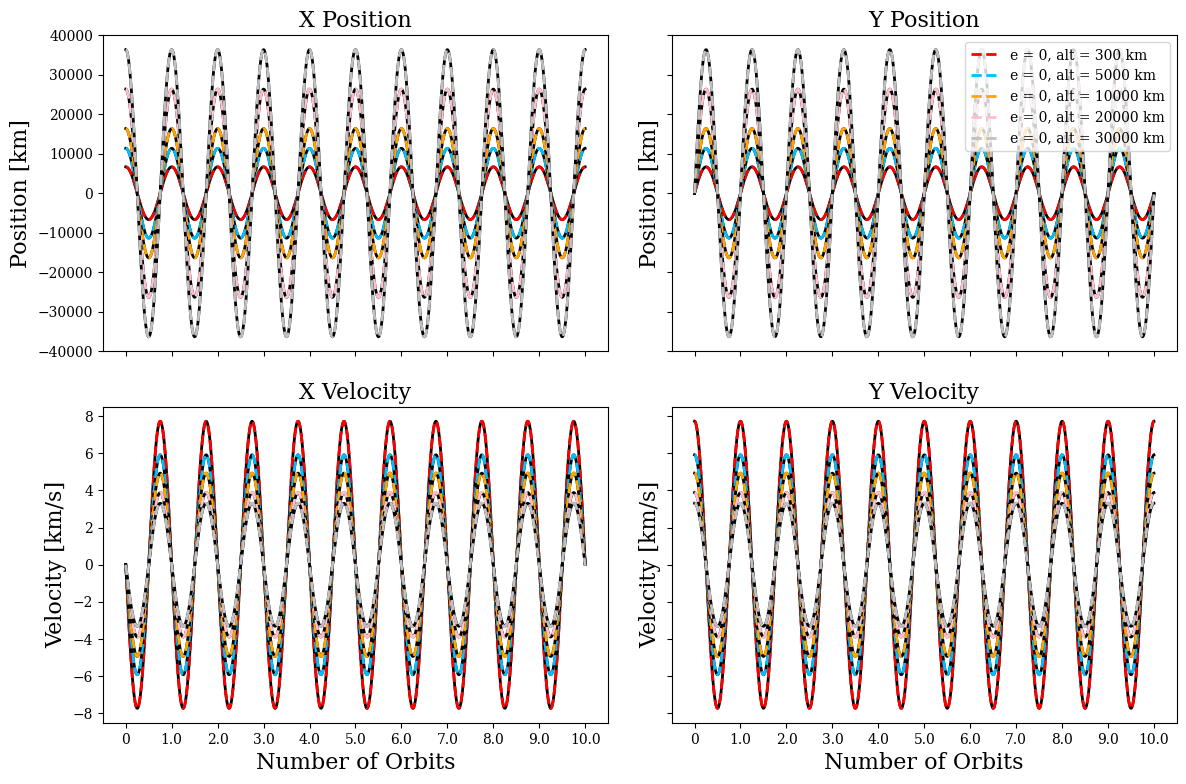

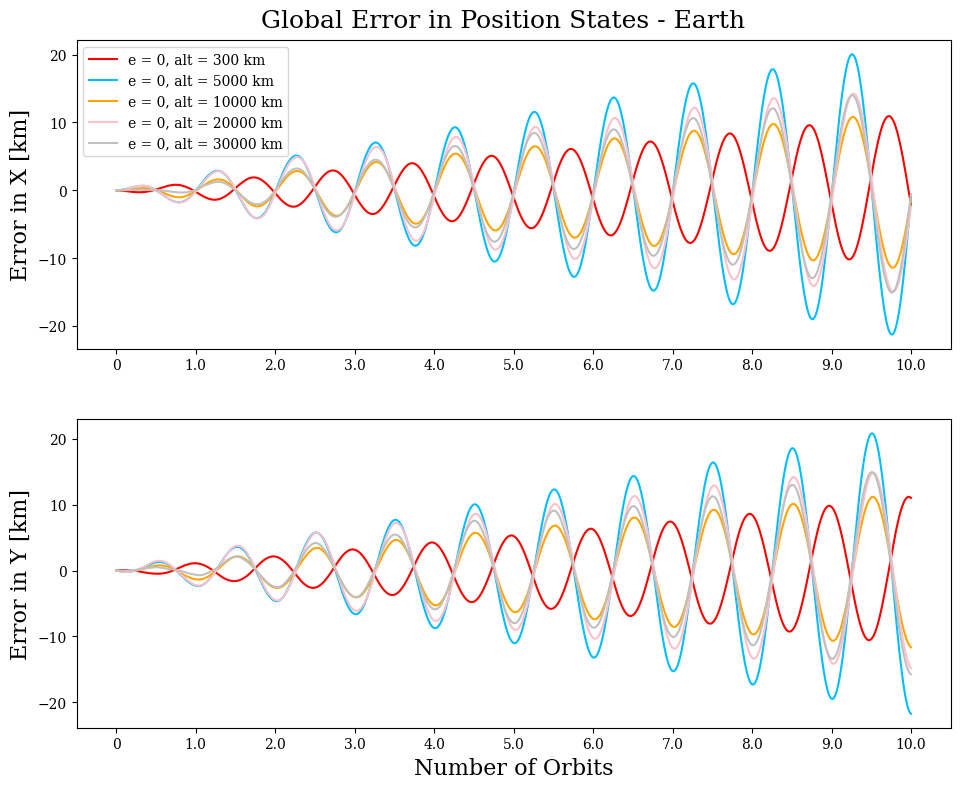

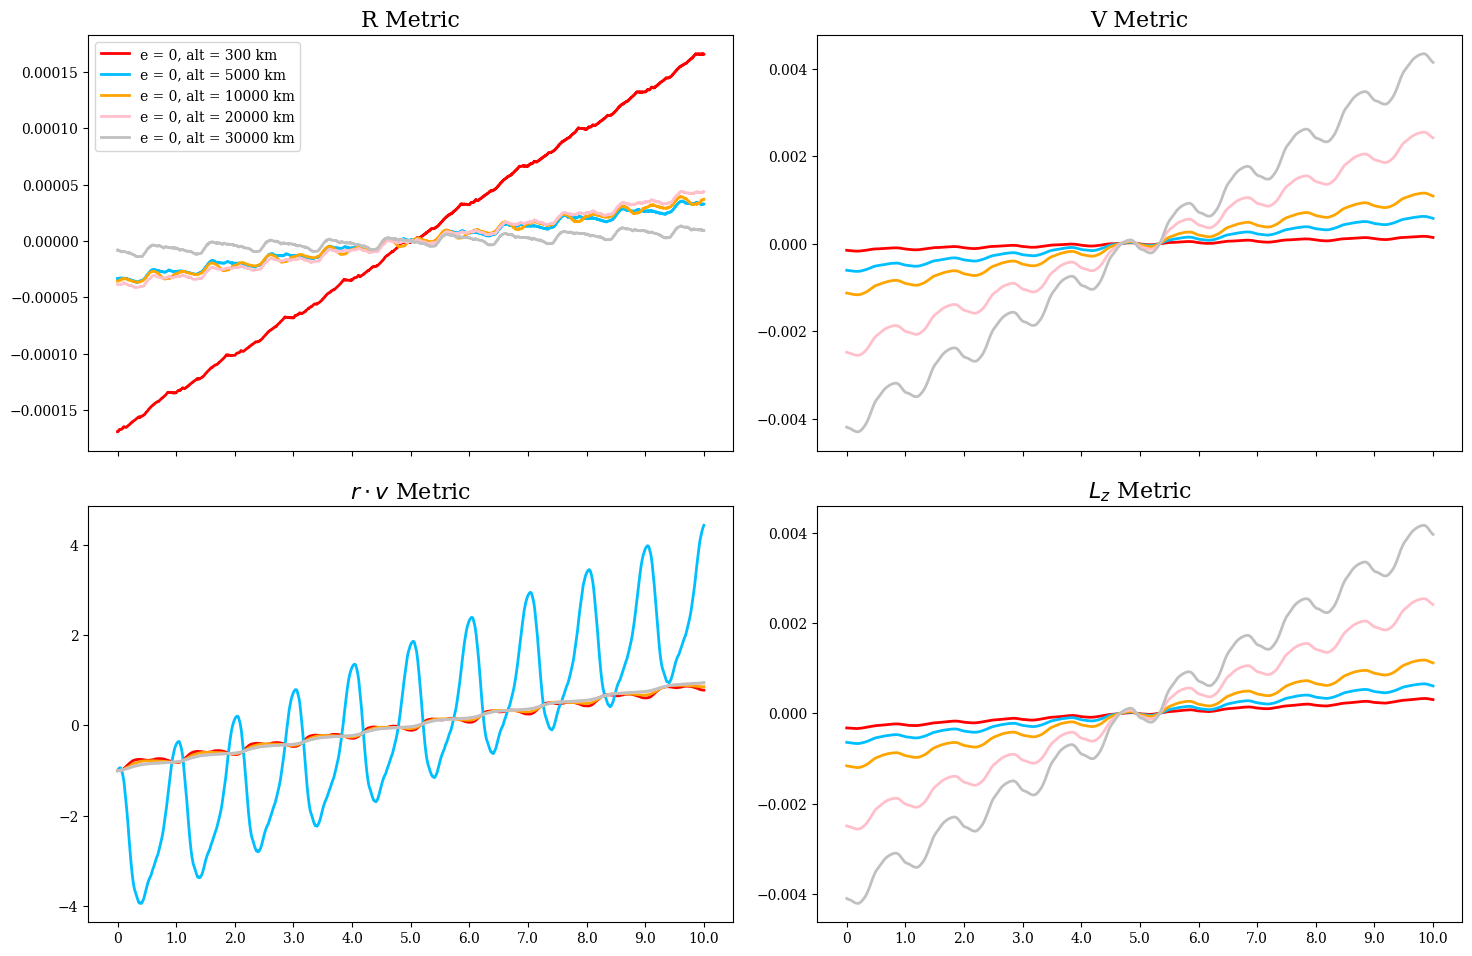

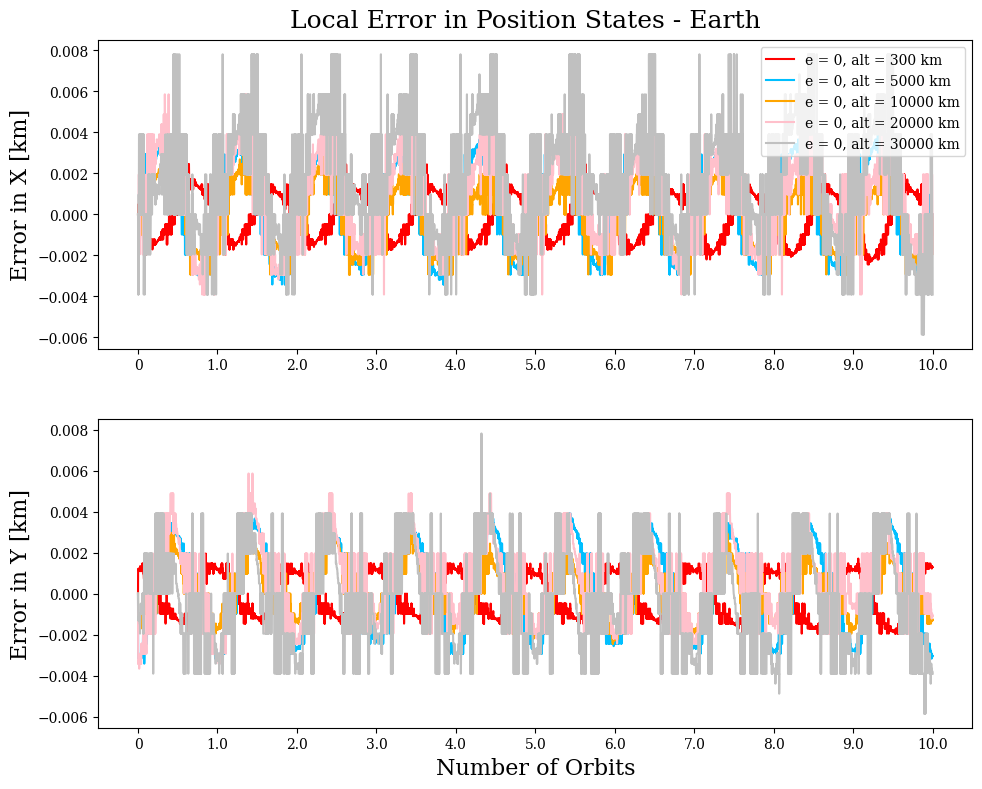

In [9]:
# Two Body Problem parameters
G = 6.6742e-20 # Gravitational constant [m^3*kg^-1*s^-2]
r_Earth = 6378.14  # Average radius of Earth [km]
m1 = 5.974e24 # mass of Earth [kg]
m2 = 1000 # mass of satellite [kg]
mu_Earth = G*(m1 + m2) # gravitational parameter [km^3*s^-2]
alts = [300, 5000, 10000, 20000, 30000]
ecc = [0, 0, 0, 0, 0]
num_traj = len(alts)
num_orbits = 1
dp = num_orbits*800

globalPredArray = np.empty(num_traj, dtype=object)
localPredArray = np.empty(num_traj, dtype=object)
exact = np.empty(num_traj, dtype=object)

# Orbital Dynamics 
for j, (alt, e) in enumerate(zip(alts,ecc)):
    rp = r_Earth + alt # radius of Perigee [km]
    ra = (rp + e*rp)/(1-e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = int(2*torch.pi*(a**3/mu_Earth)**0.5) # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu_Earth*((2/rp) - (1/a)))**0.5

    x_0 = torch.tensor([[x], [y], [x_dot], [y_dot]])
    time = np.linspace(0, num_orbits*int(period), dp)
    dt = num_orbits*int(period)/dp

    # ~~~~~~ Creating array to store system state at time k ~~~~~~~ #
    globalPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of global loss
    localPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of local loss
    NL_sol = torch.empty([nx,0]) # separate trajectory for nonlinear solution
    i = 0

    # ~~~~~~ Creating tensors to store system states ~~~~~~~ #
    xG = x_0.to(device)
    xL = x_0.to(device)
    xk = x_0

# ~~~~~~ System Evolution ~~~~~~~ #
    for t in time:

        # ~~~~~~~~ Saving Current State in Array ~~~~~~~~ #
        globalPred = torch.hstack((globalPred, xG)) # saving states
        localPred = torch.hstack((localPred, xL)) # saving states

        # ~~~~~~~~~~ Lifting of States ~~~~~~~~~~ #
        globalEncoded = model_circ(torch.transpose(xG,0,1))
        localEncoded = model_circ(torch.transpose(xk,0,1).to(device))
        phihatGlobal = torch.cat((xG,torch.transpose(globalEncoded,0,1)),0)
        phihatLocal = torch.cat((xk.to(device),torch.transpose(localEncoded,0,1)),0)

        # ~~~~~~~~~ Straight Koopman Prediction ~~~~~~~~~ #
        phihatGlobal_p1 = torch.matmul(K, phihatGlobal)
        phihatLocal_p1 = torch.matmul(K, phihatLocal)

        # ~~~~~~~~~~ Extracting States ~~~~~~~~~~ #
        xG = torch.matmul(P,phihatGlobal_p1) # extracting the next state
        xL = torch.matmul(P,phihatLocal_p1) # extracting the next state

        # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
        NL_sol = np.hstack((NL_sol, xk))
        xk = rk4(orbitdyn2D, t, xk, mu_Earth, dt) # RK4 approximation of solution
        i = i+1

    globalPredArray[j] = globalPred
    localPredArray[j] = localPred
    exact[j] = NL_sol

# ~~~~~~~~~~~~~~~~~~~~ Plotting the orbits ~~~~~~~~~~~~~~~~~~~~~~#

Earth_plot = Plotter.Plotter(exact, globalPredArray, r_Earth, alts, ecc, num_orbits, 'Earth', 1, 'earth')
Earth_plot.perifocalPlot()

# ~~~~~~~~~~~~~~~~~~~ Plotting the States ~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.statePlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Global Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.errorPlot('Global')

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Accuracy Metrics ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Earth_plot.metricPlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Local Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
Earth_plot = Plotter.Plotter(exact, localPredArray, r_Earth, alts, ecc, num_orbits, 'Earth', 0, 'earth')
Earth_plot.errorPlot('Local')

# ***Moon Orbits***

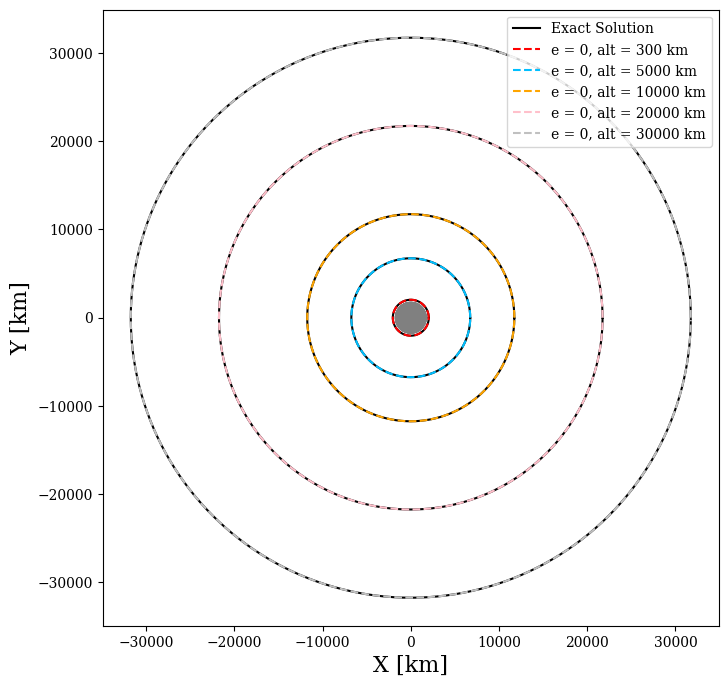

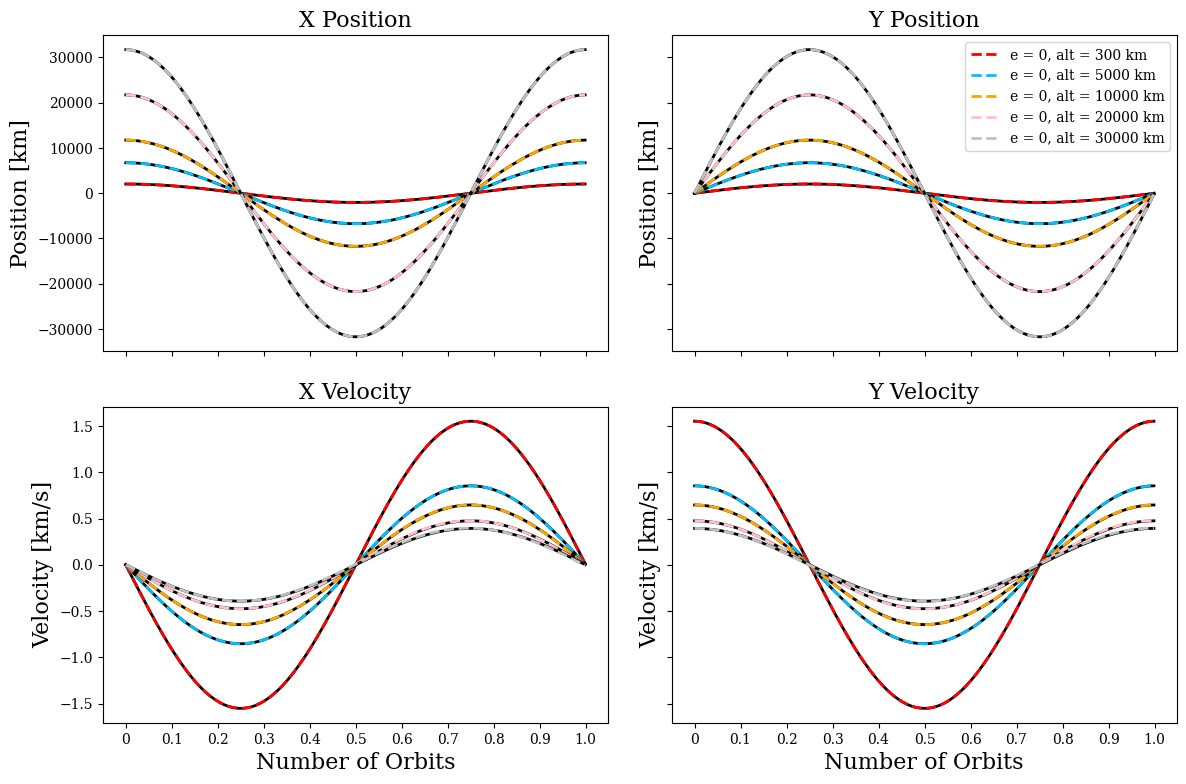

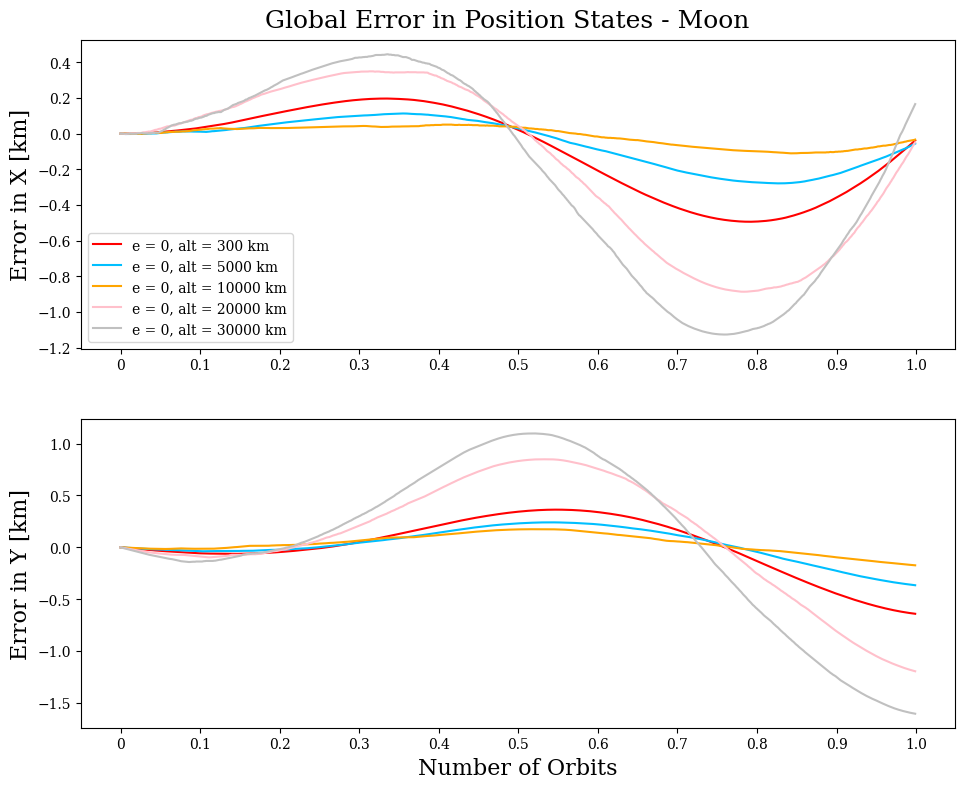

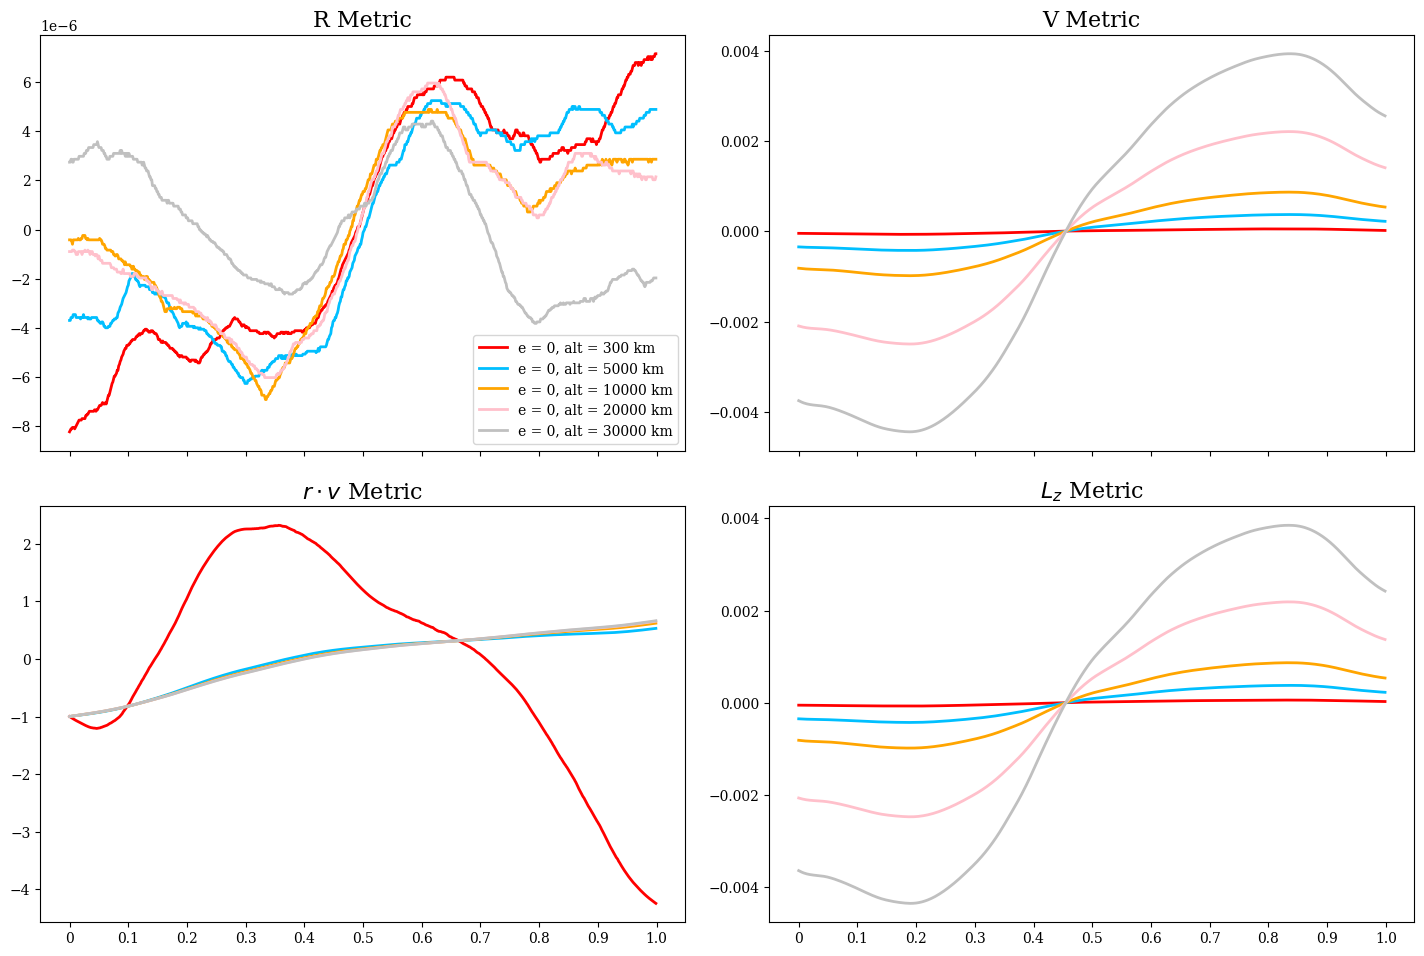

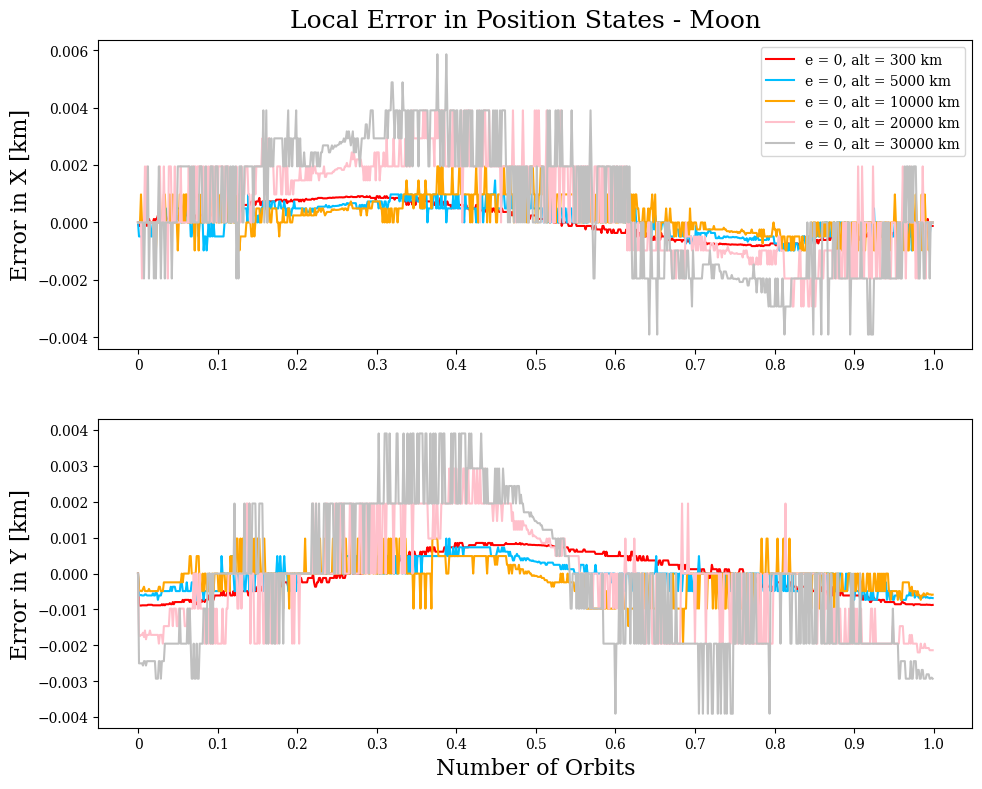

In [ ]:
# Two Body Problem parameters
G = 6.6742e-20 # Gravitational constant [m^3*kg^-1*s^-2]
r_Moon = 1737.4  # Average radius of Moon [km]
m1 = 7.35e22 # mass of Moon [kg]
m2 = 1000 # mass of satellite [kg]
mu_Moon = G*(m1 + m2) # gravitational parameter [km^3*s^-2]
alts = [300, 5000, 10000, 20000, 30000]
ecc = [0, 0, 0, 0, 0]
num_orbits = 1
dp = num_orbits*800

globalPredArray = np.empty(num_traj, dtype=object)
localPredArray = np.empty(num_traj, dtype=object)
exact = np.empty(num_traj, dtype=object)

# Orbital Dynamics 
for j, (alt, e) in enumerate(zip(alts,ecc)):
    rp = r_Moon + alt # radius of Perigee [km]
    ra = (rp + e*rp)/(1-e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = int(2*torch.pi*(a**3/mu_Moon)**0.5) # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu_Moon*((2/rp) - (1/a)))**0.5

    x_0 = torch.tensor([[x], [y], [x_dot], [y_dot]])
    time = np.linspace(0, num_orbits*int(period), dp)
    dt = num_orbits*int(period)/dp

    # ~~~~~~ Creating array to store system state at time k ~~~~~~~ #
    globalPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of global loss
    localPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of local loss
    NL_sol = torch.empty([nx,0]) # separate trajectory for nonlinear solution
    i = 0

    # ~~~~~~ Creating tensors to store system states ~~~~~~~ #
    xG = x_0.to(device)
    xL = x_0.to(device)
    xk = x_0

# ~~~~~~ System Evolution ~~~~~~~ #
    for t in time:

        # ~~~~~~~~ Saving Current State in Array ~~~~~~~~ #
        globalPred = torch.hstack((globalPred, xG)) # saving states
        localPred = torch.hstack((localPred, xL)) # saving states

        # ~~~~~~~~~~ Lifting of States ~~~~~~~~~~ #
        globalEncoded = model_circ(torch.transpose(xG,0,1))
        localEncoded = model_circ(torch.transpose(xk,0,1).to(device))
        phihatGlobal = torch.cat((xG,torch.transpose(globalEncoded,0,1)),0)
        phihatLocal = torch.cat((xk.to(device),torch.transpose(localEncoded,0,1)),0)

        # ~~~~~~~~~ Straight Koopman Prediction ~~~~~~~~~ #
        phihatGlobal_p1 = torch.matmul(K, phihatGlobal)
        phihatLocal_p1 = torch.matmul(K, phihatLocal)

        # ~~~~~~~~~~ Extracting States ~~~~~~~~~~ #
        xG = torch.matmul(P,phihatGlobal_p1) # extracting the next state
        xL = torch.matmul(P,phihatLocal_p1) # extracting the next state

        # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
        NL_sol = np.hstack((NL_sol, xk))
        xk = rk4(orbitdyn2D, t, xk, mu_Moon, dt) # RK4 approximation of solution
        
        i = i+1

    globalPredArray[j] = globalPred
    localPredArray[j] = localPred
    exact[j] = NL_sol

# ~~~~~~~~~~~~~~~~~~~~ Plotting the orbits ~~~~~~~~~~~~~~~~~~~~~~#

Moon_plot = Plotter.Plotter(exact, globalPredArray, r_Moon, alts, ecc, num_orbits, 'Moon', 0, 'moon')
Moon_plot.perifocalPlot()

# ~~~~~~~~~~~~~~~~~~~ Plotting the States ~~~~~~~~~~~~~~~~~~~~~ #

Moon_plot.statePlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Global Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Moon_plot.errorPlot('Global')

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Accuracy Metrics ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Moon_plot.metricPlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Local Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
Moon_plot = Plotter.Plotter(exact, localPredArray, r_Moon, alts, ecc, num_orbits, 'Moon', 0, 'moon')
Moon_plot.errorPlot('Local')

# ***Jupiter Orbits***

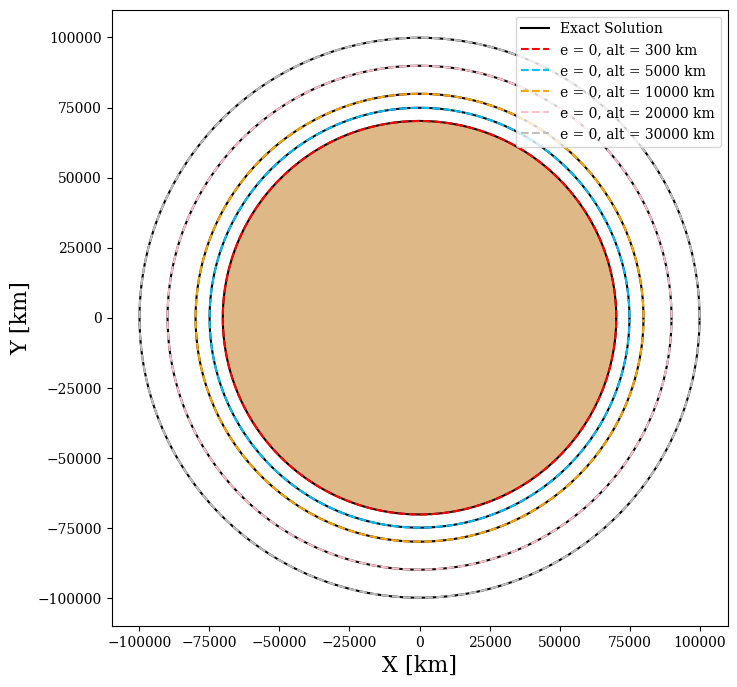

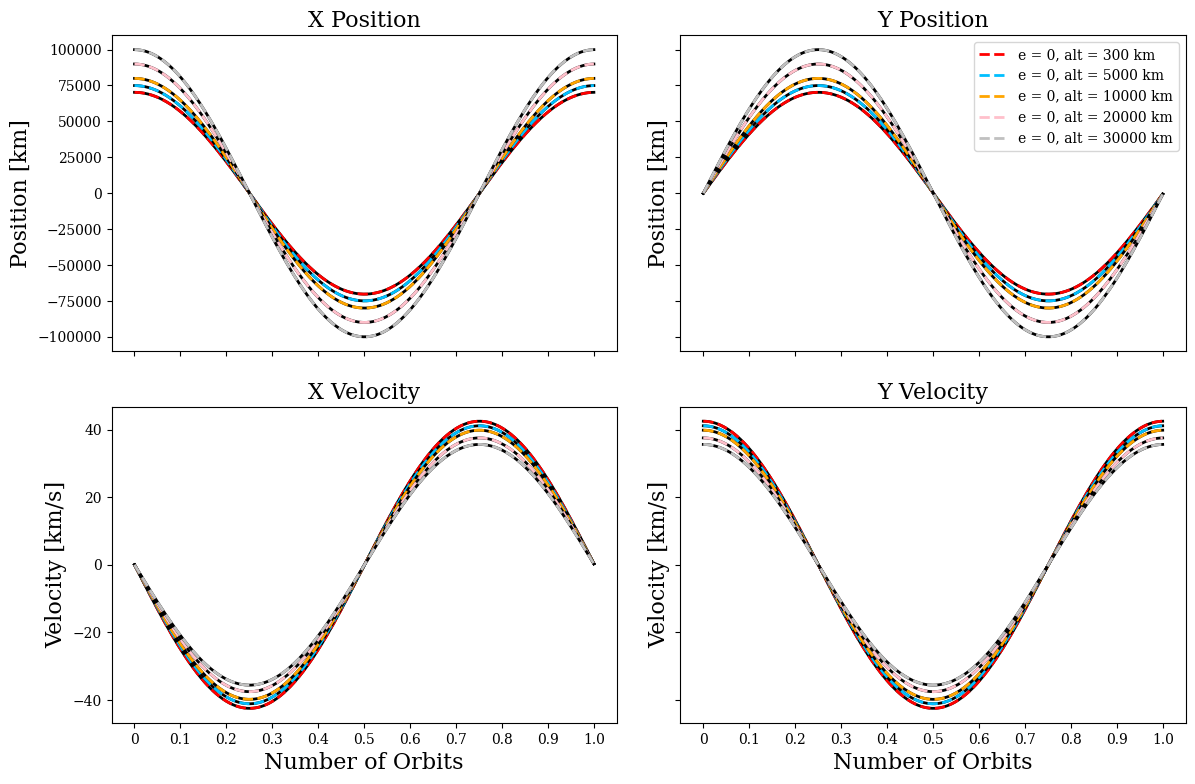

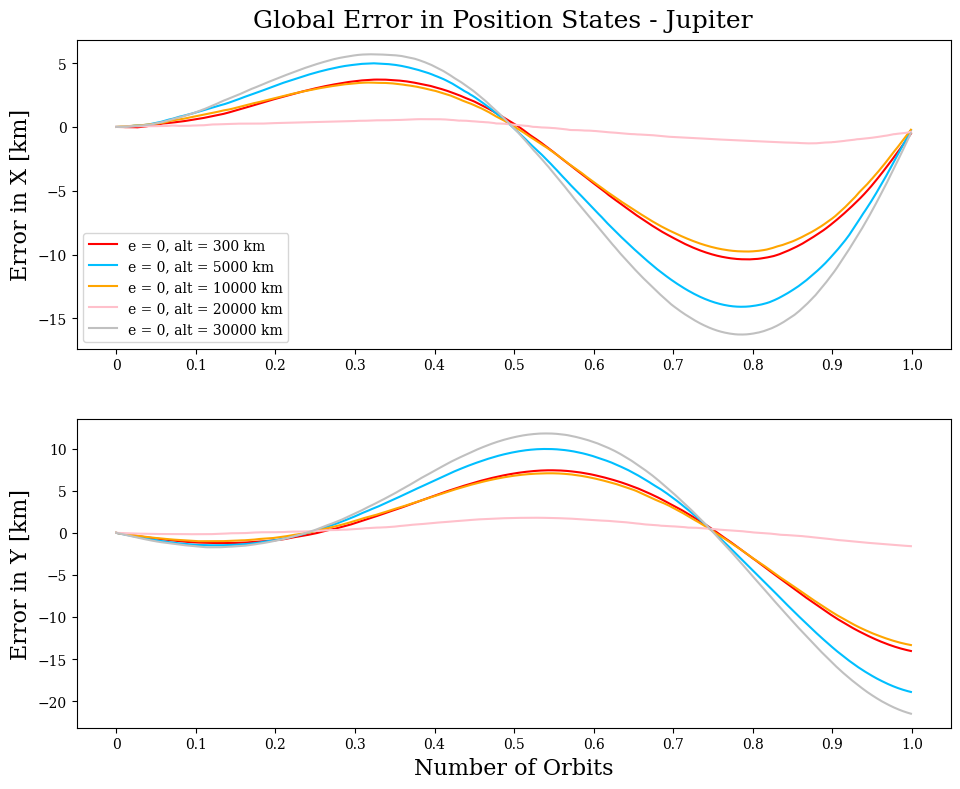

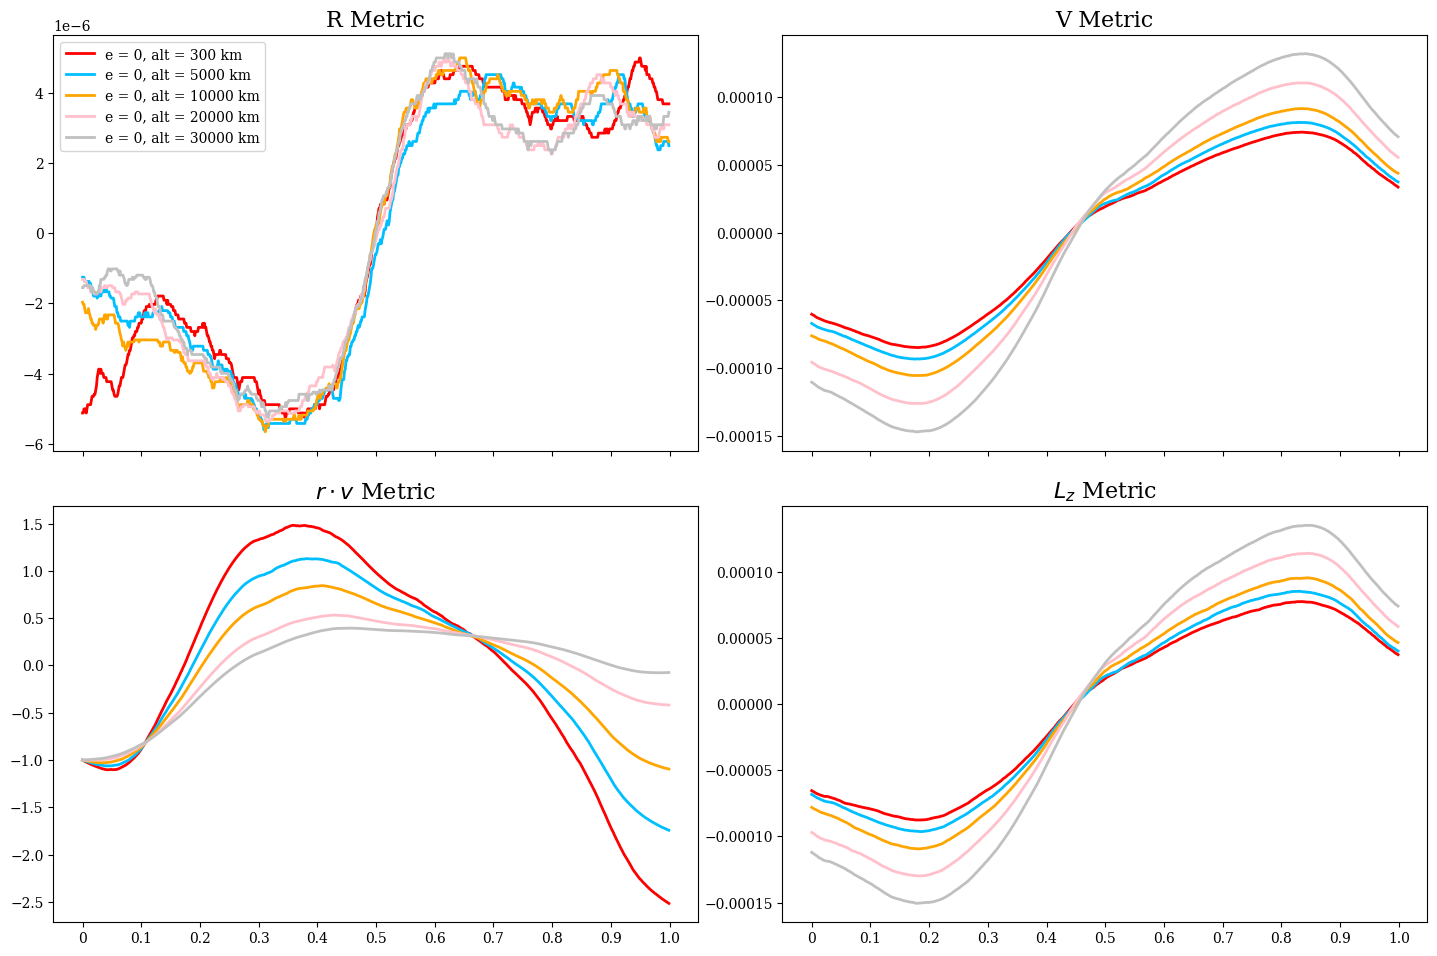

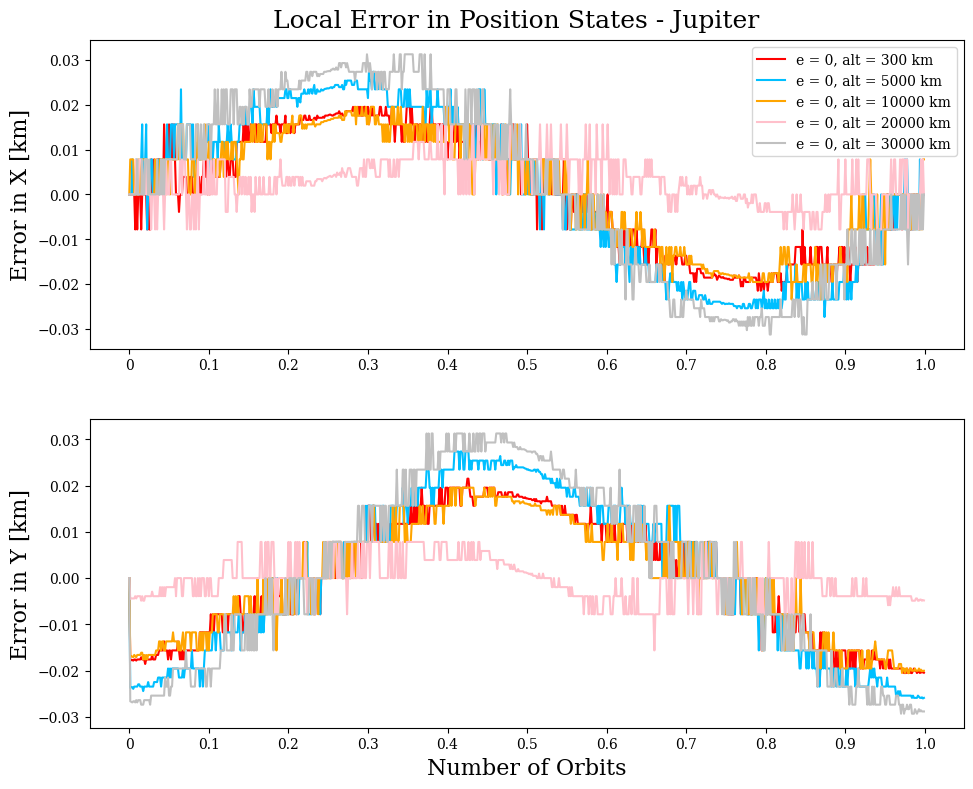

In [ ]:
# Two Body Problem parameters
G = 6.6742e-20 # Gravitational constant [m^3*kg^-1*s^-2]
r_Jupiter = 69911  # Average radius of Jupiter [km]
m1 = 1.898e27 # mass of Jupiter [kg]
m2 = 1000 # mass of satellite [kg]
mu_Jupiter = G*(m1 + m2) # gravitational parameter [km^3*s^-2]
alt = [300, 5000, 10000, 20000, 30000]
num_orbits = 1
dp = num_orbits*800

globalPredArray = np.empty(num_traj, dtype=object)
localPredArray = np.empty(num_traj, dtype=object)
exact = np.empty(num_traj, dtype=object)

# Orbital Dynamics 
for j, (alt, e) in enumerate(zip(alts,ecc)):
    rp = r_Jupiter + alt # radius of Perigee [km]
    ra = (rp + e*rp)/(1-e)
    a = (rp + ra)/2 # Semi-Major axis [km]
    period = int(2*torch.pi*(a**3/mu_Jupiter)**0.5) # Period of Orbit

    # initial condition (start at periapsis)
    x = rp
    y = 0
    x_dot = 0
    y_dot = (mu_Jupiter*((2/rp) - (1/a)))**0.5

    x_0 = torch.tensor([[x], [y], [x_dot], [y_dot]])
    # time = torch.arange(0, num_orbits*period, 10) # simulate for dp=1000 data points
    time = np.linspace(0, num_orbits*int(period), dp)
    dt = num_orbits*int(period)/dp

    # ~~~~~~ Creating array to store system state at time k ~~~~~~~ #
    globalPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of global loss
    localPred = torch.empty([nx,0]).to(device) # separate trajectory for calculation of local loss
    NL_sol = torch.empty([nx,0]) # separate trajectory for nonlinear solution
    i = 0

    # ~~~~~~ Creating tensors to store system states ~~~~~~~ #
    xG = x_0.to(device)
    xL = x_0.to(device)
    xk = x_0

# ~~~~~~ System Evolution ~~~~~~~ #
    for t in time:

        # ~~~~~~~~ Saving Current State in Array ~~~~~~~~ #
        globalPred = torch.hstack((globalPred, xG)) # saving states
        localPred = torch.hstack((localPred, xL)) # saving states

        # ~~~~~~~~~~ Lifting of States ~~~~~~~~~~ #
        globalEncoded = model_circ(torch.transpose(xG,0,1))
        localEncoded = model_circ(torch.transpose(xk,0,1).to(device))
        phihatGlobal = torch.cat((xG,torch.transpose(globalEncoded,0,1)),0)
        phihatLocal = torch.cat((xk.to(device),torch.transpose(localEncoded,0,1)),0)

        # ~~~~~~~~~ Straight Koopman Prediction ~~~~~~~~~ #
        phihatGlobal_p1 = torch.matmul(K, phihatGlobal)
        phihatLocal_p1 = torch.matmul(K, phihatLocal)

        # ~~~~~~~~~~ Extracting States ~~~~~~~~~~ #
        xG = torch.matmul(P,phihatGlobal_p1) # extracting the next state
        xL = torch.matmul(P,phihatLocal_p1) # extracting the next state

        # ~~~~~~~ Exact Nonlinear Dynamics ~~~~~~~~ #
        NL_sol = np.hstack((NL_sol, xk))
        xk = rk4(orbitdyn2D, t, xk, mu_Jupiter, dt) # RK4 approximation of solution
        i = i+1

    globalPredArray[j] = globalPred
    localPredArray[j] = localPred
    exact[j] = NL_sol

# ~~~~~~~~~~~~~~~~~~~~ Plotting the orbits ~~~~~~~~~~~~~~~~~~~~~~#

Jupiter_plot = Plotter.Plotter(exact, globalPredArray, r_Jupiter, alts, ecc, num_orbits, 'Jupiter', 0, 'jupiter')
Jupiter_plot.perifocalPlot()

# ~~~~~~~~~~~~~~~~~~~ Plotting the States ~~~~~~~~~~~~~~~~~~~~~ #

Jupiter_plot.statePlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Global Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Jupiter_plot.errorPlot('Global')

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Accuracy Metrics ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #

Jupiter_plot.metricPlot()

# ~~~~~~~~~~~~~~~~~~~~~~~~ Plotting the Local Error ~~~~~~~~~~~~~~~~~~~~~~~~~~~~ #
Jupiter_plot = Plotter.Plotter(exact, localPredArray, r_Jupiter, alts, ecc, num_orbits, 'Jupiter', 0, 'jupiter')
Jupiter_plot.errorPlot('Local')